In [1]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import utils

In [2]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

In [3]:
data_dir="/app/models/trident/retention/engineered_update_2022_06"
churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels.dropna(subset=['churn'],inplace=True)

In [4]:
def data_merge_yearly(churn_df, policy_df, buffer):
    policy_id=[]
    policy_anniv_dt=[]
    orig_policy_eff_dt=[]
    policy_term_dt=[]
    year=[]
    month=[]
    pivot_date=[]
    survival_year=[]
    survival_month=[]
    churn=[]
    for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):           
            
        policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
        policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
        if np.isnan(policy_term_month):
            date1=str(row["year"])+str(int(policy_anniv_month))
            date2=pd.to_datetime(str(date1),format="%Y%m")
        else:
            date1=str(row["year"])+str(int(policy_term_month))
            date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)

        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        
        
        x2=pd.to_datetime(row["target_dt"])
        x1=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_year.append(int((x2.year-x1.year)))
        
        x4=pd.to_datetime(row["target_dt"])
        x3=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_month.append(int((x4-x3)/np.timedelta64(1,"M")))
        
        policy_anniv_dt.append(row["policy_anniv_dt"])
        policy_term_dt.append(row["policy_term_dt"])
        orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
        
        churn.append(row["churn"])
        
    churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                             "pivot_date":pivot_date,"year":year,"month":month,"survival_year":survival_year,"survival_month":survival_month,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data.drop_duplicates(inplace=True)
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    
    df=pd.merge(churn_data,policy_df,how="inner", on=["policy_id", "year","month"])
    df.sort_values(by=["policy_id","year"],ascending=True,inplace=True)
    
    return churn_data, df

In [5]:
churn_3, df_buffer_3=data_merge_yearly(churn_labels,policy_premium_df, buffer=3)

100%|██████████| 445559/445559 [08:57<00:00, 828.90it/s]


In [6]:
data_dir="/app/models/dij22"
df_buffer_3.to_pickle(os.path.join(data_dir,"df_buffer_3_survival"))

In [7]:
data_dir="/app/models/dij22"
df_buffer_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_survival"))

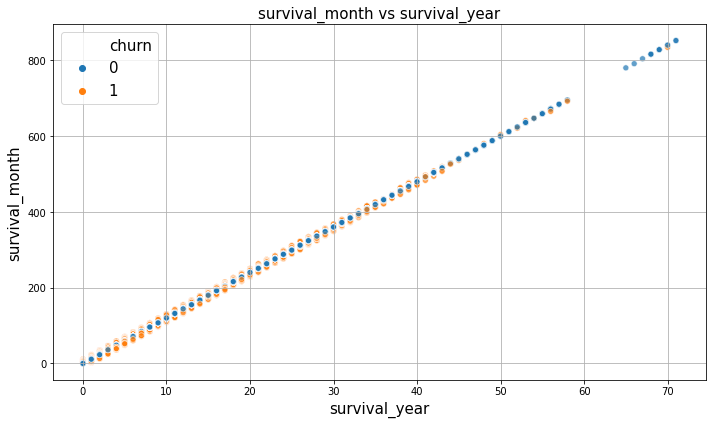

In [8]:
fig = plt.subplots(nrows=1,ncols=1,figsize =(10, 6))
ax = sns.scatterplot(data = df_buffer_3, x='survival_year',y="survival_month", hue="churn",  alpha=0.7, edgecolors="k")
ax.set_title("survival_month vs survival_year",fontsize=15)
ax.legend(fontsize=15)
ax.set_ylabel("survival_month",fontsize=15)
ax.set_xlabel("survival_year",fontsize=15)

plt.grid()
plt.tight_layout()
plt.show()

In [9]:
def pcut_func(df,var,nbin=5):
    df[var]=df[var].astype(float)
    df["cut"]=pd.qcut(df[var],nbin,precision=2,duplicates="drop")
    decile=df.groupby(df["cut"])['churn'].mean().reset_index()
    decile["cut"]=decile["cut"].astype(str)
    return decile

def myplot(df,var,*args):

    fig, a = plt.subplots(len(args)//2,2,figsize=(12,2.5*len(args)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      df=args[idx]
      ax.plot(df["cut"],df["churn"],color="r",marker="*",linewidth=2, markersize=12)
      ax.set_title(f"Bin of {var[idx]}",fontsize=15)
      ax.set_ylabel("churn rate",fontsize=10)
      ax.set_xlabel("bucket",fontsize=10)
      ax.tick_params(labelrotation=45)
    fig.tight_layout()

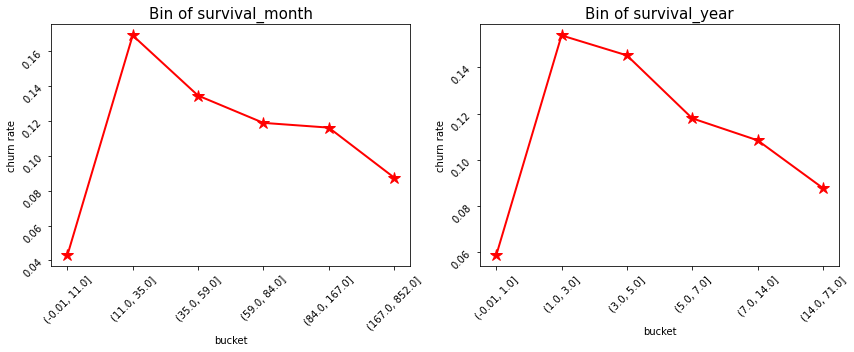

In [10]:

variable_list=["survival_month","survival_year"]
nbin=6
args=[]
for idx,v in enumerate(variable_list):
    x=pcut_func(df_buffer_3,var=variable_list[idx],nbin=nbin)
    args.append(x)

myplot(df_buffer_3,variable_list,*args)

In [11]:
def train_test_data(data,feature_type,test_yr):
    df=data.copy()
    all_var=df.columns.tolist()
    exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month","orig_policy_eff_dt", "policy_anniv_dt", "policy_term_dt"]
    exclude_var=[]
    
    if feature_type=="original":
        for col in all_var:
            if col[:2] in ["L1","L2","L3","L6","L12",'d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
                exclude_var.append(col)
                
    elif feature_type=="original+rolling window":
        for col in all_var:
            if col[:2] in ['d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
                exclude_var.append(col)
    
    elif feature_type=="original+rolling window+delta":
        for col in all_var:
            if col[:2] in ["r1","r2","r3","r6","r12"]:
                exclude_var.append(col)
                
    elif feature_type=="original+rolling window+delta+ratio":
        exclude_var=[]
    
    else:
        raise NotImplemented("Unknown feature type.")
                
    df.drop(exclude_var, axis=1,inplace=True)
    train_data=df[df["year"]!=test_yr]
    test_data=df[df["year"]==test_yr]

    y_train=train_data.loc[:,"churn"]
    y_test=test_data.loc[:,"churn"]
    X_train=train_data.drop(exclude_cols, axis=1)
    X_test=test_data.drop(exclude_cols, axis=1)

    return X_train, X_test, y_train, y_test


def model_eval(X_train,X_test,y_train,y_test):
    opt_params = utils.bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000,metrics="binary_logloss")
    train_data = lightgbm.Dataset(X_train, label=y_train)
    test_data = lightgbm.Dataset(X_test, label=y_test)
    model = lightgbm.train(opt_params,
                           train_data,
                           valid_sets=[train_data,test_data],
                           num_boost_round=5000,
                           early_stopping_rounds=100)

    feature_importance= (pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
        }).sort_values('importance', ascending=False))
    feature_importance["rank"]=list(range(len(model.feature_name())))
    feature_importance=feature_importance.loc[:,["rank","feature","importance"]].reset_index(drop=True)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_eval=utils.model_evaluate(y_train, train_preds)
    test_eval=utils.model_evaluate(y_test, test_preds)
    
    return model, feature_importance, train_eval, test_eval

def evaluation_table(eval_v1,eval_v2,eval_v3,eval_v4,type):
    dict_data={}
    dict_data["Features"]=["original feature","original + rolling window feature","original + rolling window + delta feature","original + rolling window + delta  + ratio feature"]
    # dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)] 
    dict_data["# of sample"]=[eval_v1['nb_example'],eval_v2['nb_example'],eval_v3['nb_example'],eval_v4['nb_example']]
    # dict_data["true_prediction"]=[eval_v1['true_prediction'],eval_v2['true_prediction'],eval_v3['true_prediction']]
    # dict_data["false_prediction"]=[eval_v1['false_prediction'],eval_v2['false_prediction'],eval_v3['false_prediction']]
    # dict_data["accuracy"]=[eval_v1['accuracy'],eval_v2['accuracy'],eval_v3['accuracy']]
    dict_data["precision"]=[eval_v1['precision'],eval_v2['precision'],eval_v3['precision'],eval_v4['precision']]  
    dict_data["recall"]=[eval_v1['recall'],eval_v2['recall'],eval_v3['recall'],eval_v4['recall']] 
    dict_data["f1_score"]=[eval_v1['f1_score'],eval_v2['f1_score'],eval_v3['f1_score'],eval_v4['f1_score']] 
    dict_data["ROC-AUC"]=[eval_v1['AUC'],eval_v2['AUC'],eval_v3['AUC'],eval_v4['AUC']] 
    dict_data["pr-auc"]=[eval_v1['pr_auc'],eval_v2['pr_auc'],eval_v3['pr_auc'],eval_v4['pr_auc']] 
    data_df=pd.DataFrame(dict_data)
    # data_df=data_df.set_index("Model Type")
    # data_df.style.format({"# of sample":"{:,}","true_prediction":"{:,}","false_prediction":"{:,}","accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    return data_df.style.format({"# of sample":"{:,}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    .set_caption(f"Model Performance Comparison {type}")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

# 3 month buffer

In [12]:
df_buffer_3.drop("survival_month", axis=1,inplace=True)

In [13]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original",test_yr=2022)
print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

training features:            291,135             
testing features:             35,095              


,churn
0,96.84%
1,3.16%


In [14]:
model_v03, feature_importance_v03, train_eval_v03, test_eval_v03=model_eval(X_train,X_test,y_train,y_test)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
|  1        |  0.3415   |  0.9738   |  0.2812   |  0.5985   |  49.98    |  24.1     |  10.26    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.3445   |  0.9909   |  0.7939   |  0.9862   |  84.63    |  12.59    |  86.15    |  12.12    |  67.99    |  0.258    |
|  3        |  0.3425   |  0.548    |  0.8548   |  0.8278   |  56.28    |  26.84    |  62.05    |  45.01    |  62.09    |  0.4252   |
|  4        |  0.3392   |  0.8202   |  0.5869   |  0.1144   |  87.62    |  23.97    |  71.17    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.3424   |  0.9864 

ValueError: Circular reference detected

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window",test_yr=2022)
model_v13, feature_importance_v13, train_eval_v13, test_eval_v13=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window+delta",test_yr=2022)
model_v23, feature_importance_v23, train_eval_v23, test_eval_v23=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window+delta+ratio",test_yr=2022)
model_v33, feature_importance_v33, train_eval_v33, test_eval_v33=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
evaluation_table(train_eval_v03,train_eval_v13,train_eval_v23,train_eval_v33,"Training Set")

In [ ]:
evaluation_table(test_eval_v03,test_eval_v13,test_eval_v23,test_eval_v33,"Test Set")

In [ ]:
def feature_importance(model):
    df_feature_importance = (
        pd.DataFrame({
            'feature': model.feature_name(),
            'importance': model.feature_importance(),
        }).sort_values('importance', ascending=False)
    )
    df_feature_importance["rank"]=list(range(len(model.feature_name())))
    df_feature_importance=df_feature_importance.loc[:,["rank","feature","importance"]].reset_index(drop=True)
    return df_feature_importance

df_feature_importance_v0=feature_importance(model_v03)
df_feature_importance_v1=feature_importance(model_v13)
df_feature_importance_v2=feature_importance(model_v23)
df_feature_importance_v3=feature_importance(model_v33)
f0=df_feature_importance_v0.loc[:30,['rank','feature']].rename(columns={"feature":"original feature"})
f1=df_feature_importance_v1.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window feature"})
f2=df_feature_importance_v2.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window + delta feature"})
f3=df_feature_importance_v3.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window + delta + ratio feature"})

feature_importance=pd.merge(f0,f1,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f2,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f3,how="inner",on="rank")
# feature_importance.style.format().set_caption("Top 20 important Features").set_table_styles([{
#     'selector': 'caption',
#     'props': [
#         ('color', 'red'),
#         ('font-size', '20px')
#     ]
# }])
feature_importance

## using survival months

In [ ]:
data_dir="/app/models/dij22"
df_buffer_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_survival"))
df_buffer_3.drop("survival_year", axis=1,inplace=True)


In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original",test_yr=2022)
model_v03, feature_importance_v03, train_eval_v03, test_eval_v03=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window",test_yr=2022)
model_v13, feature_importance_v13, train_eval_v13, test_eval_v13=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window+delta",test_yr=2022)
model_v23, feature_importance_v23, train_eval_v23, test_eval_v23=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
X_train, X_test, y_train, y_test=train_test_data(df_buffer_3,feature_type="original+rolling window+delta+ratio",test_yr=2022)
model_v33, feature_importance_v33, train_eval_v33, test_eval_v33=model_eval(X_train,X_test,y_train,y_test)

In [ ]:
evaluation_table(train_eval_v03,train_eval_v13,train_eval_v23,train_eval_v33,"Training Set")

In [ ]:
evaluation_table(test_eval_v03,test_eval_v13,test_eval_v23,test_eval_v33,"Test Set")

In [ ]:
def feature_importance(model):
    df_feature_importance = (
        pd.DataFrame({
            'feature': model.feature_name(),
            'importance': model.feature_importance(),
        }).sort_values('importance', ascending=False)
    )
    df_feature_importance["rank"]=list(range(len(model.feature_name())))
    df_feature_importance=df_feature_importance.loc[:,["rank","feature","importance"]].reset_index(drop=True)
    return df_feature_importance

df_feature_importance_v0=feature_importance(model_v03)
df_feature_importance_v1=feature_importance(model_v13)
df_feature_importance_v2=feature_importance(model_v23)
df_feature_importance_v3=feature_importance(model_v33)
f0=df_feature_importance_v0.loc[:30,['rank','feature']].rename(columns={"feature":"original feature"})
f1=df_feature_importance_v1.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window feature"})
f2=df_feature_importance_v2.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window + delta feature"})
f3=df_feature_importance_v3.loc[:30,['rank','feature']].rename(columns={"feature":"original + rolling window + delta + ratio feature"})

feature_importance=pd.merge(f0,f1,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f2,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f3,how="inner",on="rank")
# feature_importance.style.format().set_caption("Top 20 important Features").set_table_styles([{
#     'selector': 'caption',
#     'props': [
#         ('color', 'red'),
#         ('font-size', '20px')
#     ]
# }])
feature_importance